# Setup

In [1]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import gmean
from scipy.stats import linregress
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors
import seaborn as sns

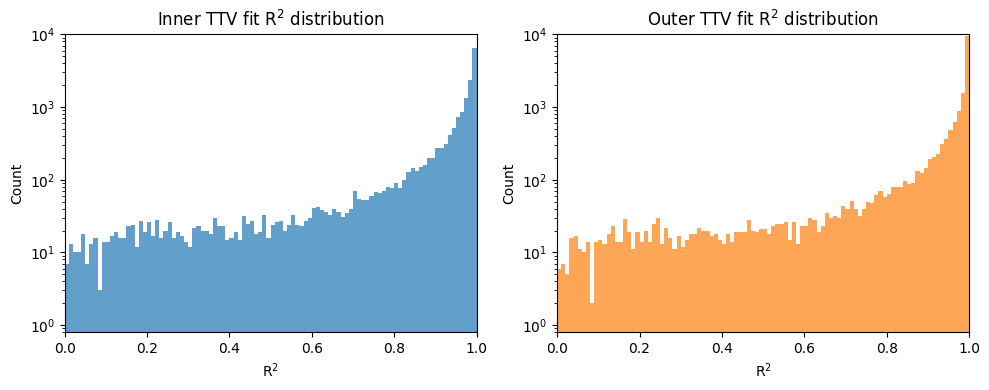

e1          w1        e2          w2     Delta  mmr  j  N  P1  \
0  0.047400  100.700641  0.217648  119.317930 -0.021691  3:1  3  2   7   
1  0.164720  302.045726  0.068150  303.935202  0.017168  3:1  3  2   7   
2  0.240904  196.166685  0.042103  127.431653  0.021325  3:1  3  2   7   
3  0.078053  285.258275  0.049500  192.127677  0.018148  3:1  3  2   7   
4  0.265350   58.254765  0.175747  166.960578 -0.016945  3:1  3  2   7   

          P2  ...      res1        A2            B2        V2       Pttv2  \
0  20.544486  ...  0.000067 -0.000015 -1.173741e-08  0.000116  313.172780   
1  21.360529  ...  0.000020 -0.000036  5.713402e-08  0.000769  417.966282   
2  21.447826  ...  0.000003  0.000004 -3.248262e-08  0.002090  336.237511   
3  21.381102  ...  0.000021 -0.000174  3.644199e-07  0.004491  393.228677   
4  20.644161  ...  0.000082  0.000047  6.474477e-07  0.006396  403.496518   

     phase2      std2          res2      R2_1      R2_2  
0  4.781314  0.000114  7.858627e-05  0.484460  0.521410  
1  0.937092  0.000539  6.910964e-07  0.994776  0.999998  
2  6.069884  0.001458  3.050189e-05  0.999123  0.999562  
3  2.220415  0.003156  3.006960e-05  0.998246  0.999909  
4  1.967924  0.004533  4.578169e-04  0.986277  0.989802  

[5 rows x 33 columns]

In [2]:
# Import CSV for fits
fits = pd.read_csv(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME\validation\2nd_order_TTVFast\deckagol_TTVFast_fits.csv")
fits = fits[fits.valid == True]
total = len(fits)

# R2-score histograms
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
valid = (fits.valid == True)

ax[0].hist(fits['R2_1'], bins=100, color='C0', alpha=0.7, range=(0, 1))
ax[0].set_title('Inner TTV fit R$^2$ distribution')

ax[1].hist(fits['R2_2'], bins=100, color='C1', alpha=0.7, range=(0, 1))
ax[1].set_title('Outer TTV fit R$^2$ distribution')

for a in ax:
    a.set_xlabel('R$^2$'); a.set_ylabel('Count')
    a.set_ylim(0.8,1e+4); a.set_xlim(0,1)
    a.set_yscale('log')

plt.tight_layout()
plt.show()

fits.head()

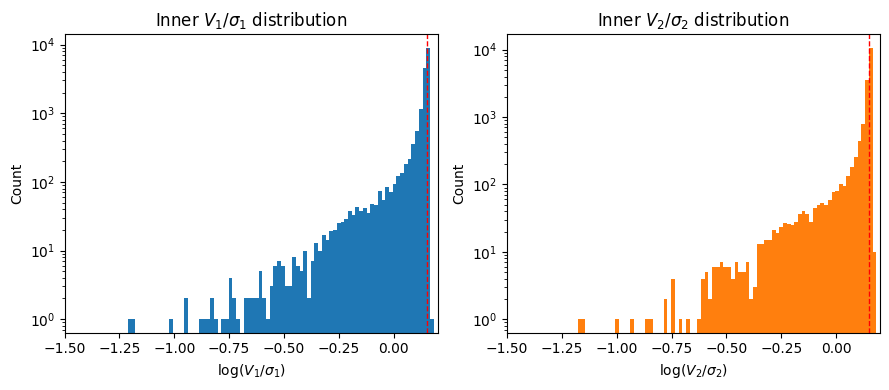

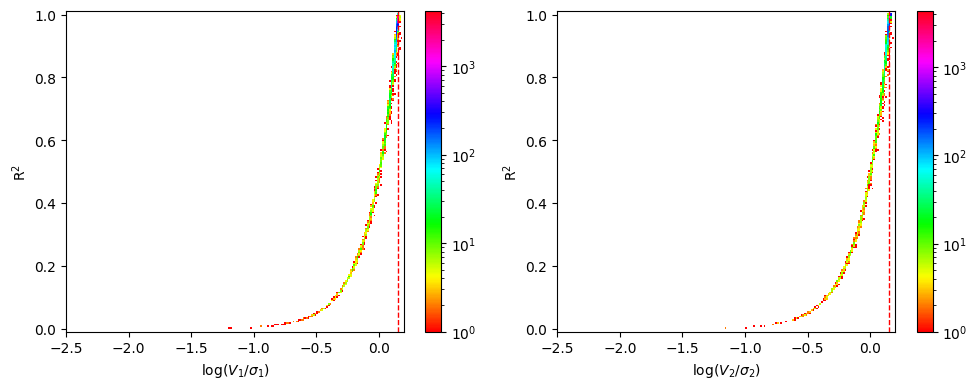

In [3]:
# Fit Amplitude / dispersion
amp_goodness1 = np.log10(np.abs(fits.V1) / fits.std1)
amp_goodness2 = np.log10(np.abs(fits.V2) / fits.std2)

# V/sigma histograms
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
rng = (-1.5, 0.2)
ax[0].hist(amp_goodness1, bins=100, range=rng, color='C0')
ax[1].hist(amp_goodness2, bins=100, range=rng, color='C1')

for i, a in enumerate(ax):
    a.set_title(f'Inner $V_{i+1}/\sigma_{i+1}$ distribution')
    a.set_yscale('log')
    a.set_xlim(rng)
    a.set_xlabel(f'$\log(V_{i+1}/\sigma_{i+1})$'); a.set_ylabel('Count')
    a.axvline(np.log10(np.sqrt(2)), color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

# V/sigma-R2 scatterplot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

rng = [(-2.5, 0.2), (-0.01, 1.01)]
h0 = ax[0].hist2d(amp_goodness1, fits.R2_1, bins=200, range=rng, norm=mcolors.LogNorm(), cmap='hsv')
h1 = ax[1].hist2d(amp_goodness2, fits.R2_2, bins=200, range=rng, norm=mcolors.LogNorm(), cmap='hsv')

plt.colorbar(h0[3], ax=ax[0])
plt.colorbar(h1[3], ax=ax[1])

for i, a in enumerate(ax):
    a.set_xlim(rng[0]), a.set_ylim(rng[1])
    a.set_xlabel(f'$\log(V_{i+1}/\sigma_{i+1})$'); a.set_ylabel('R$^2$')
    a.axvline(np.log10(np.sqrt(2)), color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

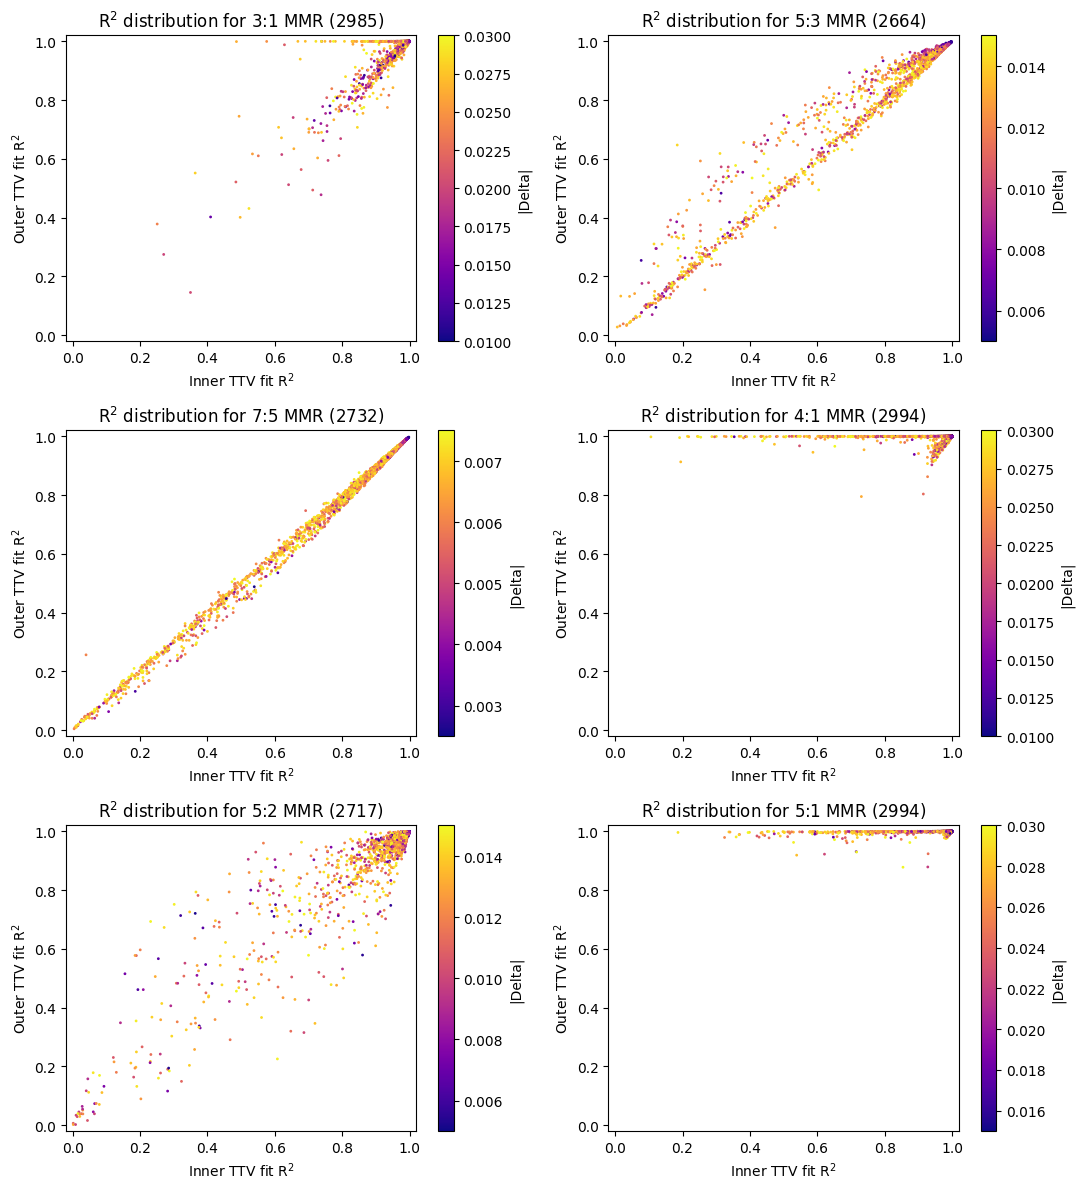

In [4]:
# R2-score scatterplots 1
fig, ax = plt.subplots(3, 2, figsize=(11,12))

mmr_list = ['3:1', '5:3', '7:5', '4:1', '5:2', '5:1']
coord_list = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1)]

for mmr, coords in zip(mmr_list, coord_list):
    ccol = 'Delta'  # Colormap column
    mmr_mask = (fits.mmr == mmr) & (fits.valid == True)
    mmr_tot = mmr_mask.sum()
    color = np.abs(fits[ccol][mmr_mask])
    # Round vmin and vmax to nearest 0.005
    vmin = np.round(np.min(color) / 0.0025) * 0.0025
    vmax = np.round(np.max(color) / 0.0025) * 0.0025
    
    sc = ax[coords].scatter(fits['R2_1'][mmr_mask], fits['R2_2'][mmr_mask], s=1,
                            c=color, cmap='plasma',
                            vmin=vmin, vmax=vmax)
    ax[coords].set_xlabel('Inner TTV fit R$^2$'); ax[coords].set_ylabel('Outer TTV fit R$^2$')
    ax[coords].set_xlim(-0.02,1.02); ax[coords].set_ylim(-0.02,1.02)
    ax[coords].set_title(f'R$^2$ distribution for {mmr} MMR ({mmr_tot})')
    
    fig.colorbar(sc, ax=ax[coords], label='|Delta|')

plt.tight_layout()
plt.show()

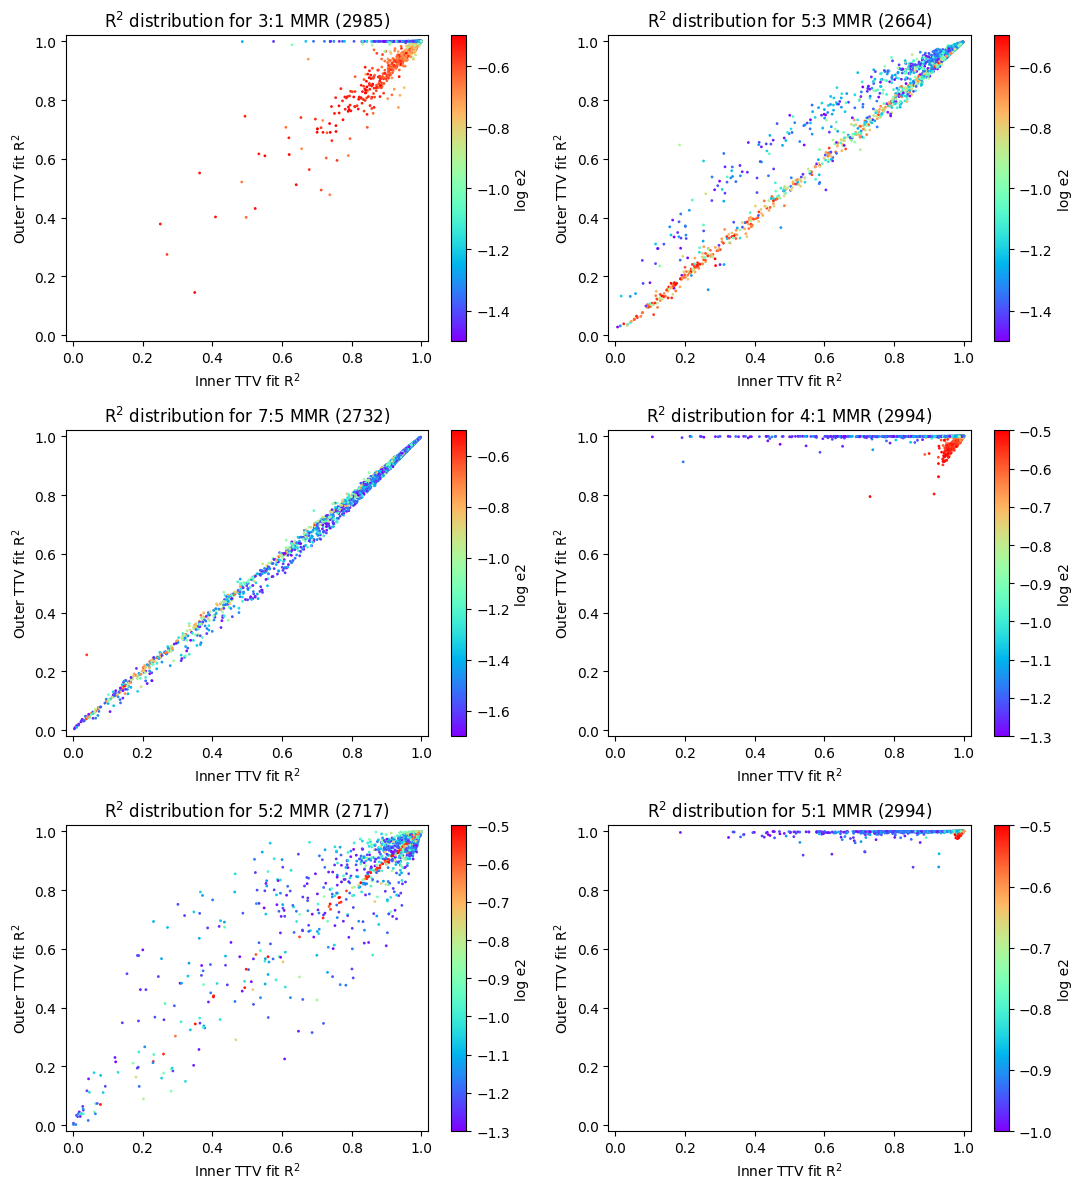

In [5]:
# R2-score scatterplots 2
fig, ax = plt.subplots(3, 2, figsize=(11,12))

mmr_list = ['3:1', '5:3', '7:5', '4:1', '5:2', '5:1']
coord_list = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1)]

for mmr, coords in zip(mmr_list, coord_list):
    ccol = 'e2'  # Colormap column
    mmr_mask = (fits.mmr == mmr) & (fits.valid == True)
    mmr_tot = mmr_mask.sum()
    color = np.log10(fits[ccol][mmr_mask])
    # Round vmin and vmax to nearest 0.1
    vmin = np.round(np.min(color) / 0.1) * 0.1
    vmax = np.round(np.max(color) / 0.1) * 0.1
    
    sc = ax[coords].scatter(fits['R2_1'][mmr_mask], fits['R2_2'][mmr_mask], s=1,
                            c=color, cmap='rainbow',
                            vmin=vmin, vmax=vmax)
    ax[coords].set_xlabel('Inner TTV fit R$^2$'); ax[coords].set_ylabel('Outer TTV fit R$^2$')
    ax[coords].set_xlim(-0.02,1.02); ax[coords].set_ylim(-0.02,1.02)
    ax[coords].set_title(f'R$^2$ distribution for {mmr} MMR ({mmr_tot})')
    
    fig.colorbar(sc, ax=ax[coords], label='log e2')

plt.tight_layout()
plt.show()

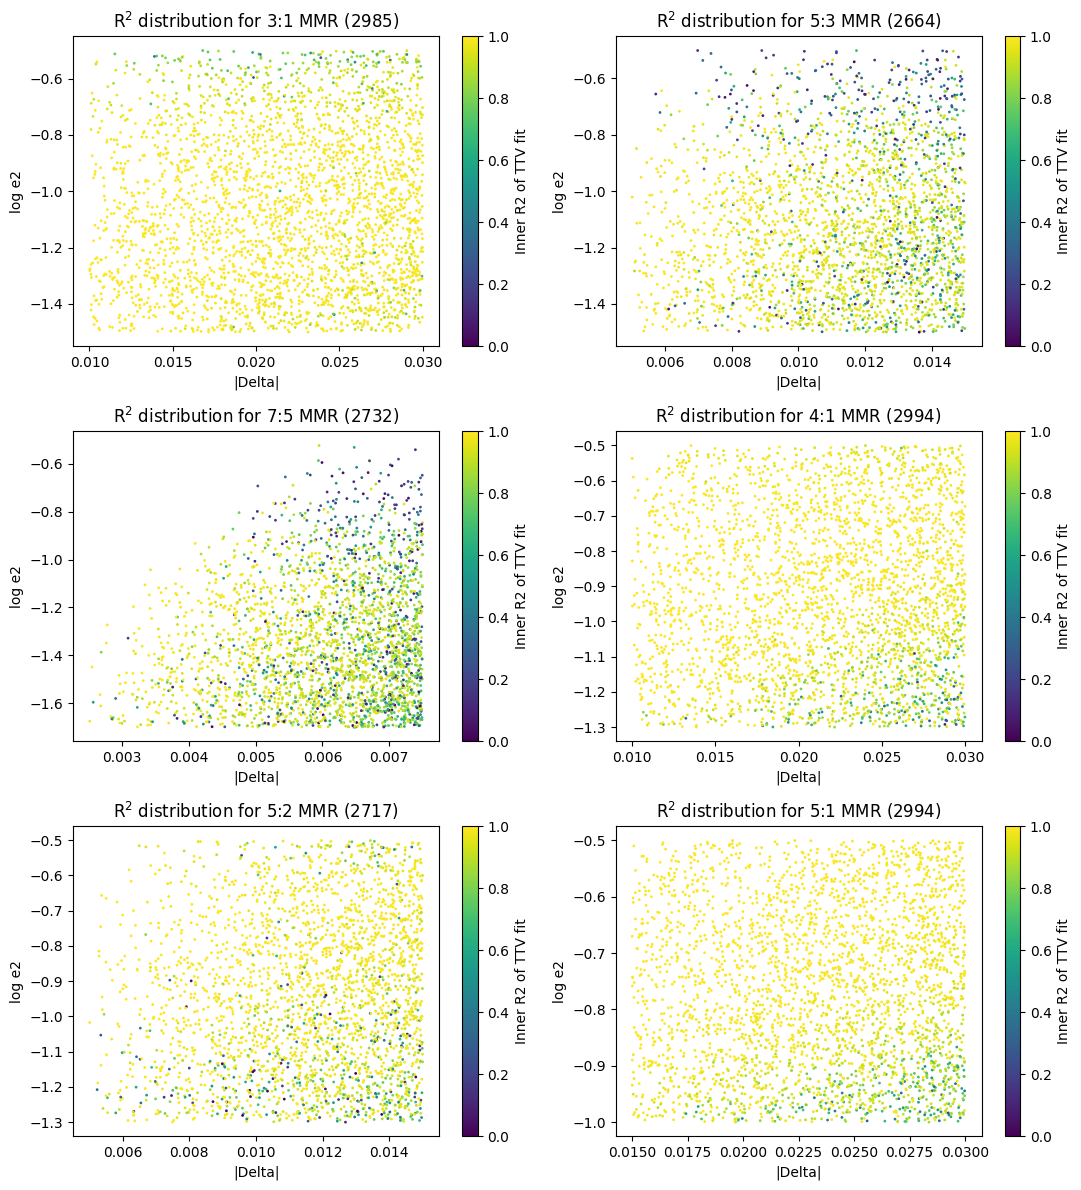

In [6]:
# R2-score scatterplots 3
fig, ax = plt.subplots(3, 2, figsize=(11,12))

mmr_list = ['3:1', '5:3', '7:5', '4:1', '5:2', '5:1']
coord_list = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1)]

for mmr, coords in zip(mmr_list, coord_list):
    ccol = 'e2'  # Colormap column
    mmr_mask = (fits.mmr == mmr) & (fits.valid == True)
    mmr_tot = mmr_mask.sum()
    color = np.abs(fits[ccol][mmr_mask])
    
    sc = ax[coords].scatter(np.abs(fits['Delta'][mmr_mask]), np.log10(fits[ccol][mmr_mask]), s=1,
                            c=fits['R2_1'][mmr_mask],
                            cmap='viridis', vmin=0, vmax=1)
    ax[coords].set_xlabel('|Delta|'); ax[coords].set_ylabel('log e2')
    # ax[coords].set_xlim(-0.02,1.02); ax[coords].set_ylim(-0.02,1.02)
    ax[coords].set_title(f'R$^2$ distribution for {mmr} MMR ({mmr_tot})')
    
    fig.colorbar(sc, ax=ax[coords], label='Inner R2 of TTV fit')

plt.tight_layout()
plt.show()

In [7]:
# Filter by R2
# Minimum 5% percentile
p5_1 = np.nanpercentile(fits.R2_1, 0)
p5_2 = np.nanpercentile(fits.R2_2, 0)
print(f'Filter for R^2 (Inner TTV) and R^2 (Outer TTV): {p5_1:.3f}, {p5_2:.3f}')

R2_filter = (fits.R2_1 > p5_1) & (fits.R2_2 > p5_2)
fits = fits[R2_filter].reset_index()
good = len(fits)

print(f'Good systems: {good}/{total} ({(good/total) * 100:.2f}%)')

fits.head()

Filter for R^2 (Inner TTV) and R^2 (Outer TTV): 0.002, 0.002
Good systems: 17084/17086 (99.99%)


index        e1          w1        e2          w2     Delta  mmr  j  N  P1  \
0      0  0.047400  100.700641  0.217648  119.317930 -0.021691  3:1  3  2   7   
1      1  0.164720  302.045726  0.068150  303.935202  0.017168  3:1  3  2   7   
2      2  0.240904  196.166685  0.042103  127.431653  0.021325  3:1  3  2   7   
3      3  0.078053  285.258275  0.049500  192.127677  0.018148  3:1  3  2   7   
4      4  0.265350   58.254765  0.175747  166.960578 -0.016945  3:1  3  2   7   

   ...      res1        A2            B2        V2       Pttv2    phase2  \
0  ...  0.000067 -0.000015 -1.173741e-08  0.000116  313.172780  4.781314   
1  ...  0.000020 -0.000036  5.713402e-08  0.000769  417.966282  0.937092   
2  ...  0.000003  0.000004 -3.248262e-08  0.002090  336.237511  6.069884   
3  ...  0.000021 -0.000174  3.644199e-07  0.004491  393.228677  2.220415   
4  ...  0.000082  0.000047  6.474477e-07  0.006396  403.496518  1.967924   

       std2          res2      R2_1      R2_2  
0  0.000114  7.858627e-05  0.484460  0.521410  
1  0.000539  6.910964e-07  0.994776  0.999998  
2  0.001458  3.050189e-05  0.999123  0.999562  
3  0.003156  3.006960e-05  0.998246  0.999909  
4  0.004533  4.578169e-04  0.986277  0.989802  

[5 rows x 34 columns]

In [8]:
# Functions, returns in %
def relerr(calc, sol):
    nonan = ~np.isnan(calc) & ~np.isnan(sol) 
    relerrs = calc[nonan]/sol[nonan]
    return relerrs

def err_gmean(calc, sol):
    relerrs = relerr(calc, sol)
    gavg = gmean(relerrs)
    return gavg

def err_med(calc, sol):
    relerrs = relerr(calc, sol)
    med = np.median(relerrs)
    return med

def err_gstd(calc, sol):
    relerrs = relerr(calc, sol)    
    logs = np.log(relerrs)
    gstd = np.exp(logs.std(ddof=0))
    return gstd

def err_1sig_percentiles(calc, sol):
    relerrs = relerr(calc, sol)
    p16 = np.percentile(relerrs, 16)
    p84 = np.percentile(relerrs, 84)
    return p16, p84

def num2dex(x):
    return np.log10(x)

def returnMetrics(df, mask='all', mode='gstd'):
    if isinstance(mask, str):
        if (mask == 'all'):
            m = np.ones(len(df), dtype=bool)
    else:
        m = mask
        
    err1 = err_gmean(df['m_calc_in'][m], df['m1'][m])
    err2 = err_gmean(df['m_calc_out'][m], df['m2'][m])
    med1 = err_med(df['m_calc_in'][m], df['m1'][m])
    med2 = err_med(df['m_calc_out'][m], df['m2'][m])

    if mode == 'gstd':
        gstd1 = err_gstd(df['m_calc_in'][m], df['m1'][m])
        gstd2 = err_gstd(df['m_calc_out'][m], df['m2'][m])
    
        MetricArr = err1, err2, med1, med2, gstd1, gstd2
        MetricArr = num2dex(MetricArr)
        
    elif mode == 'percentile':
        p16_1, p84_1 = err_1sig_percentiles(df['m_calc_in'][m], df['m1'][m])
        p16_2, p84_2 = err_1sig_percentiles(df['m_calc_out'][m], df['m2'][m])

        MetricArr = err1, err2, med1, med2, p16_1, p84_1, p16_2, p84_2
        MetricArr = num2dex(MetricArr)
        
    return MetricArr

In [9]:
# Fit line y = kx + c
def getLineFit(calc, sol):
    nonan = ~np.isnan(calc) & ~np.isnan(sol) & (calc/sol < 1e+3) & (calc/sol > 1e-3)
    x, y = sol[nonan], calc[nonan]

    # Linear fit using scipy
    slope, intercept, _, _, _ = linregress(x, y)
    return slope, intercept

# Non-nominal validation

In [10]:
# Naive validation
valid = fits['valid']
mmr = fits['mmr']; j = fits['j']; N = fits['N']; 
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = np.abs(fits['Pttv1']); PTTV_out = np.abs(fits['Pttv2'])
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
Mstar = 1

e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities(e1[i], w1[i], e2[i], w2[i]) for i in range(len(e1))]

mu_in_sol = (fits['m1'].values * M_earth).to(Mstar*u.M_sun).value
mu_out_sol = (fits['m2'].values * M_earth).to(Mstar*u.M_sun).value

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
mbad_out, mbad_in = np.array([]), np.array([])

for i in tqdm(range(len(mmr))):
    if valid[i] == False:  # If invalid column
        mcalc_in = np.append(mcalc_in, np.nan)
        mcalc_out = np.append(mcalc_out, np.nan)
        mbad_in = np.append(mbad_in, np.nan)
        mbad_out = np.append(mbad_out, np.nan)
        continue
    
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i])

    mu_in_expected = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i],
                                               eccentricity=z[i], inner_period=P_in[i])
    mu_out_expected = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i],
                                                eccentricity=z[i], outer_period=P_out[i])

    mu_in_closest = mu_in[np.argmin(np.abs(mu_in - mu_in_expected))]
    mu_out_closest =  mu_out[np.argmin(np.abs(mu_out - mu_out_expected))]    
    m_in = (mu_in_closest * Mstar*u.M_sun).to(u.M_earth).value
    m_out = (mu_out_closest * Mstar*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

    mu_in_bad = mu_in[np.argmax(np.abs(mu_in - mu_in_expected))]
    mu_out_bad =  mu_out[np.argmax(np.abs(mu_out - mu_out_expected))]    
    m_in_bad = (mu_in_bad * Mstar*u.M_sun).to(u.M_earth).value
    m_out_bad = (mu_out_bad * Mstar*u.M_sun).to(u.M_earth).value

    mbad_in = np.append(mbad_in, m_in_bad)
    mbad_out = np.append(mbad_out, m_out_bad)

compare = fits.copy()
compare['m_calc_in'] = mcalc_in
compare['m_calc_out'] = mcalc_out
compare['m_bad_in'] = mbad_in
compare['m_bad_out'] = mbad_out
compare.head()

100%|████████████████████████████████████████████████████████████████████████████| 17084/17084 [07:27<00:00, 38.14it/s]


index        e1          w1        e2          w2     Delta  mmr  j  N  P1  \
0      0  0.047400  100.700641  0.217648  119.317930 -0.021691  3:1  3  2   7   
1      1  0.164720  302.045726  0.068150  303.935202  0.017168  3:1  3  2   7   
2      2  0.240904  196.166685  0.042103  127.431653  0.021325  3:1  3  2   7   
3      3  0.078053  285.258275  0.049500  192.127677  0.018148  3:1  3  2   7   
4      4  0.265350   58.254765  0.175747  166.960578 -0.016945  3:1  3  2   7   

   ...       Pttv2    phase2      std2          res2      R2_1      R2_2  \
0  ...  313.172780  4.781314  0.000114  7.858627e-05  0.484460  0.521410   
1  ...  417.966282  0.937092  0.000539  6.910964e-07  0.994776  0.999998   
2  ...  336.237511  6.069884  0.001458  3.050189e-05  0.999123  0.999562   
3  ...  393.228677  2.220415  0.003156  3.006960e-05  0.998246  0.999909   
4  ...  403.496518  1.967924  0.004533  4.578169e-04  0.986277  0.989802   

   m_calc_in  m_calc_out   m_bad_in  m_bad_out  
0   0.960367    1.861141   0.667001   0.848853  
1   3.904714    3.611640   2.290838   3.124967  
2   3.300341    0.451294   2.298673   0.316631  
3  13.158129    4.864258  19.486856   5.353479  
4   1.566083    0.481641   1.483767   0.506232  

[5 rows x 38 columns]

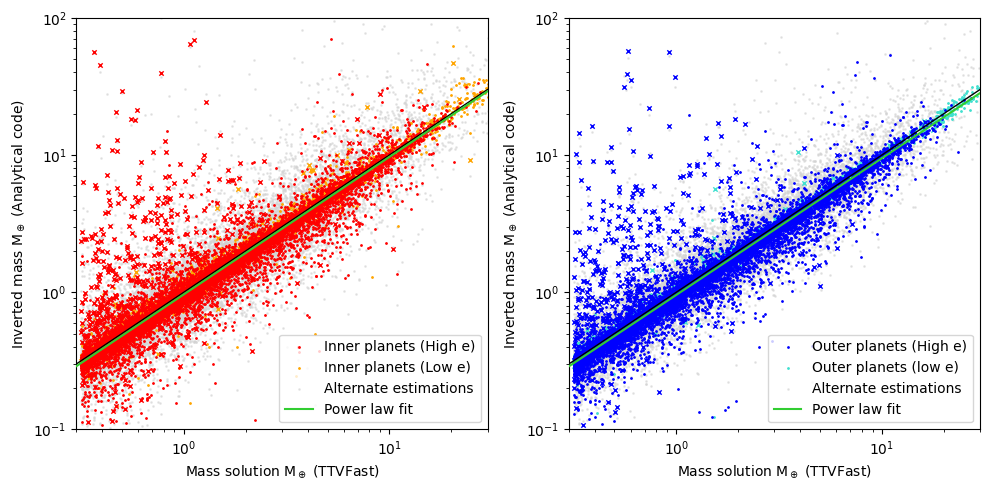

In [24]:
# Graph compare N-body outputs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
s = 1
minval_x, maxval_x = 3e-1, 3e+1
minval_y, maxval_y = 1e-1, 1e+2
linelim = np.array([minval_x, maxval_x])
scatterCount = len(compare['m1'])

ethres = 0.1
lowe = (compare.e1 < ethres) & (compare.e2 < ethres); highe = ~lowe
Rthres = 0.5
lowR = (compare.R2_1 < Rthres) | (compare.R2_2 < Rthres); highR = ~lowR

# Inner planets
m1 = compare['m1']
m1_good = compare['m_calc_in']
m1_bad = compare['m_bad_in']
k1, c1 = getLineFit(np.log10(m1_good), np.log10(m1))

ax[0].scatter(m1[highe &highR], m1_good[highe &highR], s=s, color='red', label=f'Inner planets (High e)', zorder=3)
ax[0].scatter(m1[highe & lowR], m1_good[highe & lowR], s=10*s, color='red', marker='x', lw=1, zorder=2)
ax[0].scatter(m1[lowe &highR], m1_good[lowe &highR], s=s, color='orange', label=f'Inner planets (Low e)', zorder=1)
ax[0].scatter(m1[lowe & lowR], m1_good[lowe & lowR], s=10*s, color='orange', marker='x', lw=1, zorder=0)
ax[0].scatter(m1, m1_bad, s=s, color='lightgrey', label='Alternate estimations', zorder=-1, alpha=0.5)

ax[0].plot(linelim, linelim, color='black', lw=1, zorder=5)
ax[0].plot(linelim, 10**c1 * linelim**k1, color='limegreen', zorder=5, label=f'Power law fit')
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlim(minval_x, maxval_x); ax[0].set_ylim(minval_y, maxval_y)
ax[0].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[0].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
ax[0].legend(loc='lower right')

# Outer planets
m2 = compare['m2']
m2_good = compare['m_calc_out']
m2_bad = compare['m_bad_out']
k2, c2 = getLineFit(np.log10(m2_good), np.log10(m2))

ax[1].scatter(m2[highe &highR], m2_good[highe &highR], s=s, color='blue', label=f'Outer planets (High e)', zorder=3)
ax[1].scatter(m2[highe & lowR], m2_good[highe & lowR], s=10*s, color='blue', marker='x', lw=1, zorder=2)
ax[1].scatter(m2[lowe &highR], m2_good[lowe &highR], s=s, color='turquoise', label=f'Outer planets (low e)', zorder=1)
ax[1].scatter(m2[lowe & lowR], m2_good[lowe & lowR], s=10*s, color='turquoise', marker='x', lw=1, zorder=0)
ax[1].scatter(m2, m2_bad, s=s, color='lightgrey', label='Alternate estimations', zorder=-1, alpha=0.5)

ax[1].plot(linelim, linelim, color='black', lw=1, zorder=5)
ax[1].plot(linelim, 10**c2 * linelim**k2, color='limegreen', zorder=5, label=f'Power law fit')
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlim(minval_x, maxval_x); ax[1].set_ylim(minval_y, maxval_y)
ax[1].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[1].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
ax[1].legend(loc='lower right')

fig.tight_layout()
plt.show()

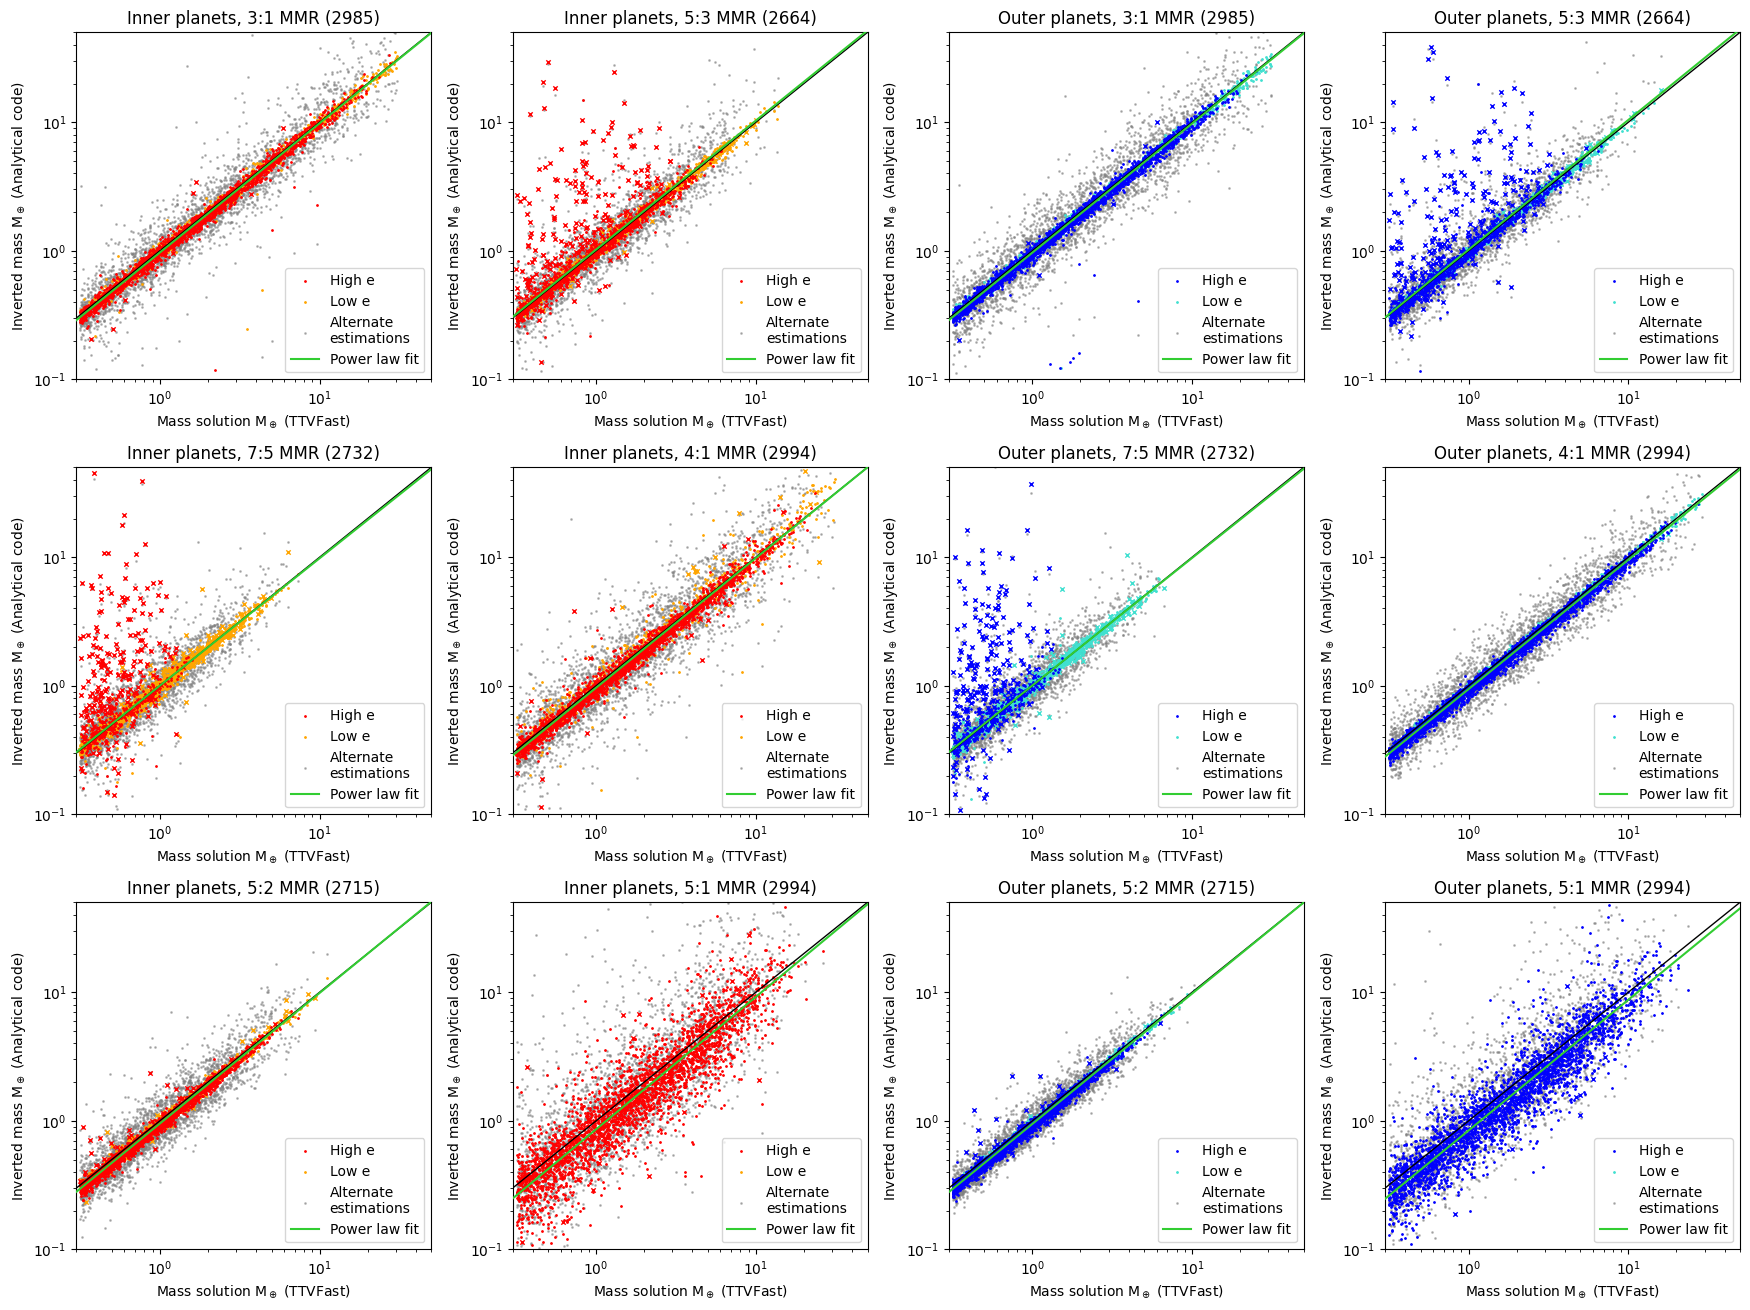

In [25]:
# Divide up by eccentricity and MMR
# Graph compare N-body outputs
fig, ax = plt.subplots(3, 4, figsize=(16*1.1, 12*1.1))

def plotMassEstimation(posTuple, x, ygood, ybad, color, innerouterStr, mask, regimeName,
                       xval=(3e-1, 5e+1), yval=(1e-1, 5e+1), mode='MMR'):
    s = 1
    minval_x, maxval_x = xval
    minval_y, maxval_y = yval
    linelim = np.array([minval_x, maxval_x])
    scatterCount = len(x[mask])
    k, c = getLineFit(np.log10(ygood[mask]), np.log10(x[mask]))

    Rthres = 0.5
    lowR = (compare.R2_1 < Rthres) | (compare.R2_2 < Rthres); highR = ~lowR

    if mode == 'eccentricity':
        ax[posTuple].scatter(x[mask & lowR], ygood[mask & lowR], s=10*s, color=color, marker='x', lw=1, zorder=1)
        ax[posTuple].scatter(x[mask &highR], ygood[mask &highR], s=s, color=color, label=f'{innerouterStr} planets', zorder=0)
    elif mode == 'MMR':
        ethres = 0.1
        lowe = (compare.e1 < ethres) & (compare.e2 < ethres); highe = ~lowe
        if color == 'red':
            altcolor = 'orange'
        elif color == 'blue':
            altcolor = 'turquoise'
        ax[posTuple].scatter(x[mask & highe & lowR], ygood[mask & highe & lowR], s=10*s, color=color, marker='x', lw=1, zorder=3)
        ax[posTuple].scatter(x[mask & highe &highR], ygood[mask & highe &highR], s=s, color=color, label=f'High e', zorder=2)
        ax[posTuple].scatter(x[mask & lowe & lowR], ygood[mask & lowe & lowR], s=10*s, color=altcolor, marker='x', lw=1, zorder=1)
        ax[posTuple].scatter(x[mask & lowe &highR], ygood[mask & lowe &highR], s=s, color=altcolor, label=f'Low e', zorder=0)

    ax[posTuple].scatter(x[mask], ybad[mask], s=s, color='grey', label='Alternate\nestimations', zorder=-1, alpha=0.5)
    ax[posTuple].plot(linelim, linelim, color='black', lw=1, zorder=5)
    ax[posTuple].plot(linelim, 10**c * linelim**k, color='limegreen', zorder=5, label=f'Power law fit')
    ax[posTuple].set_xscale('log'); ax[posTuple].set_yscale('log')
    ax[posTuple].set_xlim(minval_x, maxval_x); ax[posTuple].set_ylim(minval_y, maxval_y)
    ax[posTuple].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
    ax[posTuple].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
    ax[posTuple].legend(loc='lower right')
    ax[posTuple].set_title(f'{innerouterStr} planets, {regimeName} ({scatterCount})')

def plotMassWithRegimes(df, xval=(3e-1, 5e+1), yval=(1e-1, 5e+1)):
    def mmrmask(mmr): 
        return (compare.mmr == mmr)
    def plotInner(posTuple, mmr, mode='MMR'):
        return plotMassEstimation(posTuple, df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', mmrmask(mmr), f'{mmr} MMR',
                                 xval=xval, yval=yval, mode=mode)
    def plotOuter(posTuple, mmr, mode='MMR'):
        return plotMassEstimation(posTuple, df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', mmrmask(mmr), f'{mmr} MMR',
                                 xval=xval, yval=yval, mode=mode)

    plotInner((0,0), '3:1'); plotInner((0,1), '5:3'); plotInner((1,0), '7:5')
    plotInner((1,1), '4:1'); plotInner((2,0), '5:2'); plotInner((2,1), '5:1')

    plotOuter((0,2), '3:1'); plotOuter((0,3), '5:3'); plotOuter((1,2), '7:5')
    plotOuter((1,3), '4:1'); plotOuter((2,2), '5:2'); plotOuter((2,3), '5:1')

plotMassWithRegimes(compare)

fig.tight_layout()
plt.show()

In [13]:
# Relative bias and average error
err1, err2, med1, med2, gstd1, gstd2 = returnMetrics(compare, mask='all')

print(f'Geometric mean error, median error, and geometric STD (Inner): {err1:.3f} dex, {med1:.3f} dex, {gstd1:.3f} dex')
print(f'Geometric mean error, median error, and geometric STD (Outer): {err2:.3f} dex, {med2:.3f} dex, {gstd2:.3f} dex')

Geometric mean error, median error, and geometric STD (Inner): -0.010 dex, -0.012 dex, 0.140 dex
Geometric mean error, median error, and geometric STD (Outer): -0.016 dex, -0.018 dex, 0.129 dex


# Nominal validation

In [14]:
# Naive nominal mass validation
mmr = fits['mmr']; j = fits['j']; N = fits['N']; 
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = np.abs(fits['Pttv1']); PTTV_out = np.abs(fits['Pttv2'])
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
Mstar = 1

e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities(0.03, 0, 0.03, 0) for i in range(len(e1))]

mu_in_sol = (fits['m1'].values * M_earth).to(Mstar*u.M_sun).value
mu_out_sol = (fits['m2'].values * M_earth).to(Mstar*u.M_sun).value

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
mbad_out, mbad_in = np.array([]), np.array([])
for i in tqdm(range(len(mmr))):
    if valid[i] == False:  # If invalid column
        mcalc_in = np.append(mcalc_in, np.nan)
        mcalc_out = np.append(mcalc_out, np.nan)
        mbad_in = np.append(mbad_in, np.nan)
        mbad_out = np.append(mbad_out, np.nan)
        continue
    
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i])

    mu_in_expected = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i],
                                               eccentricity=z[i], inner_period=P_in[i])
    mu_out_expected = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i],
                                                eccentricity=z[i], outer_period=P_out[i])

    mu_in_closest = mu_in[np.argmin(np.abs(mu_in - mu_in_expected))]
    mu_out_closest =  mu_out[np.argmin(np.abs(mu_out - mu_out_expected))]    
    m_in = (mu_in_closest * Mstar*u.M_sun).to(u.M_earth).value
    m_out = (mu_out_closest * Mstar*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

    mu_in_bad = mu_in[np.argmax(np.abs(mu_in - mu_in_expected))]
    mu_out_bad =  mu_out[np.argmax(np.abs(mu_out - mu_out_expected))]    
    m_in_bad = (mu_in_bad * Mstar*u.M_sun).to(u.M_earth).value
    m_out_bad = (mu_out_bad * Mstar*u.M_sun).to(u.M_earth).value

    mbad_in = np.append(mbad_in, m_in_bad)
    mbad_out = np.append(mbad_out, m_out_bad)

compare_n = fits.copy()
compare_n['m_calc_in'] = mcalc_in
compare_n['m_calc_out'] = mcalc_out
compare_n['m_bad_in'] = mbad_in
compare_n['m_bad_out'] = mbad_out
compare_n.head()

100%|████████████████████████████████████████████████████████████████████████████| 17084/17084 [06:07<00:00, 46.43it/s]


index        e1          w1        e2          w2     Delta  mmr  j  N  P1  \
0      0  0.047400  100.700641  0.217648  119.317930 -0.021691  3:1  3  2   7   
1      1  0.164720  302.045726  0.068150  303.935202  0.017168  3:1  3  2   7   
2      2  0.240904  196.166685  0.042103  127.431653  0.021325  3:1  3  2   7   
3      3  0.078053  285.258275  0.049500  192.127677  0.018148  3:1  3  2   7   
4      4  0.265350   58.254765  0.175747  166.960578 -0.016945  3:1  3  2   7   

   ...       Pttv2    phase2      std2          res2      R2_1      R2_2  \
0  ...  313.172780  4.781314  0.000114  7.858627e-05  0.484460  0.521410   
1  ...  417.966282  0.937092  0.000539  6.910964e-07  0.994776  0.999998   
2  ...  336.237511  6.069884  0.001458  3.050189e-05  0.999123  0.999562   
3  ...  393.228677  2.220415  0.003156  3.006960e-05  0.998246  0.999909   
4  ...  403.496518  1.967924  0.004533  4.578169e-04  0.986277  0.989802   

    m_calc_in  m_calc_out    m_bad_in  m_bad_out  
0    3.182023   13.773678   12.114251   6.474905  
1   35.623586   16.527858   13.360708  28.578339  
2  189.755773    8.443795   52.321081  16.903113  
3  248.682911   33.039324   86.550598  59.282848  
4  115.251656   75.817200  307.691093  42.942172  

[5 rows x 38 columns]

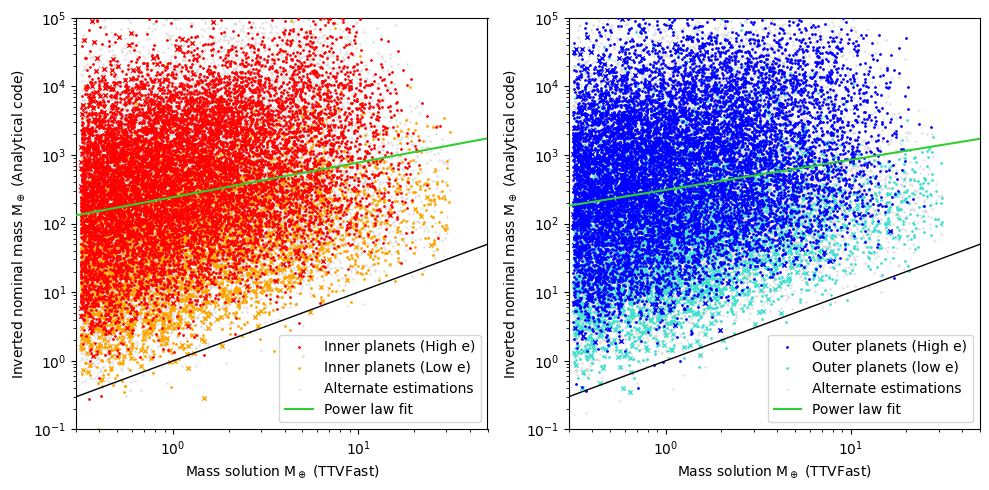

In [28]:
# Graph compare N-body outputs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
s = 1
minval_x, maxval_x = 3e-1, 0.5e+2
minval_y, maxval_y = 1e-1, 1e+5
linelim = np.array([minval_x, maxval_x])
scatterCount = len(compare_n['m1'])

ethres = 0.1
lowe = (compare.e1 < ethres) & (compare.e2 < ethres); highe = ~lowe
Rthres = 0.5
lowR = (compare.R2_1 < Rthres) | (compare.R2_2 < Rthres); highR = ~lowR

# Inner planets
m1 = compare_n['m1']
m1_good = compare_n['m_calc_in']
m1_bad = compare_n['m_bad_in']
k1, c1 = getLineFit(np.log10(m1_good), np.log10(m1))

ax[0].scatter(m1[highe &highR], m1_good[highe &highR], s=s, color='red', label=f'Inner planets (High e)', zorder=3)
ax[0].scatter(m1[highe & lowR], m1_good[highe & lowR], s=10*s, color='red', marker='x', lw=1, zorder=2)
ax[0].scatter(m1[lowe &highR], m1_good[lowe &highR], s=s, color='orange', label=f'Inner planets (Low e)', zorder=1)
ax[0].scatter(m1[lowe & lowR], m1_good[lowe & lowR], s=10*s, color='orange', marker='x', lw=1, zorder=0)
ax[0].scatter(m1, m1_bad, s=s, color='lightgrey', label='Alternate estimations', zorder=-1, alpha=0.5)

ax[0].plot(linelim, linelim, color='black', lw=1, zorder=5)
ax[0].plot(linelim, 10**c1 * linelim**k1, color='limegreen', zorder=5, label=f'Power law fit')
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlim(minval_x, maxval_x); ax[0].set_ylim(minval_y, maxval_y)
ax[0].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[0].set_ylabel('Inverted nominal mass M$_\oplus$ (Analytical code)')
ax[0].legend(loc='lower right')

# Outer planet
m2 = compare_n['m2']
m2_good = compare_n['m_calc_out']
m2_bad = compare_n['m_bad_out']
k2, c2 = getLineFit(np.log10(m2_good), np.log10(m2))

ax[1].scatter(m2[highe &highR], m2_good[highe &highR], s=s, color='blue', label=f'Outer planets (High e)', zorder=3)
ax[1].scatter(m2[highe & lowR], m2_good[highe & lowR], s=10*s, color='blue', marker='x', lw=1, zorder=2)
ax[1].scatter(m2[lowe &highR], m2_good[lowe &highR], s=s, color='turquoise', label=f'Outer planets (low e)', zorder=1)
ax[1].scatter(m2[lowe & lowR], m2_good[lowe & lowR], s=10*s, color='turquoise', marker='x', lw=1, zorder=0)
ax[1].scatter(m2, compare_n['m_bad_out'], s=s, color='lightgrey', label='Alternate estimations', zorder=-1, alpha=0.5)

ax[1].plot(linelim, linelim, color='black', lw=1, zorder=5)
ax[1].plot(linelim, 10**c2 * linelim**k2, color='limegreen', zorder=5, label=f'Power law fit')
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlim(minval_x, maxval_x); ax[1].set_ylim(minval_y, maxval_y)
ax[1].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[1].set_ylabel('Inverted nominal mass M$_\oplus$ (Analytical code)')
ax[1].legend(loc='lower right')

fig.tight_layout()
plt.show()

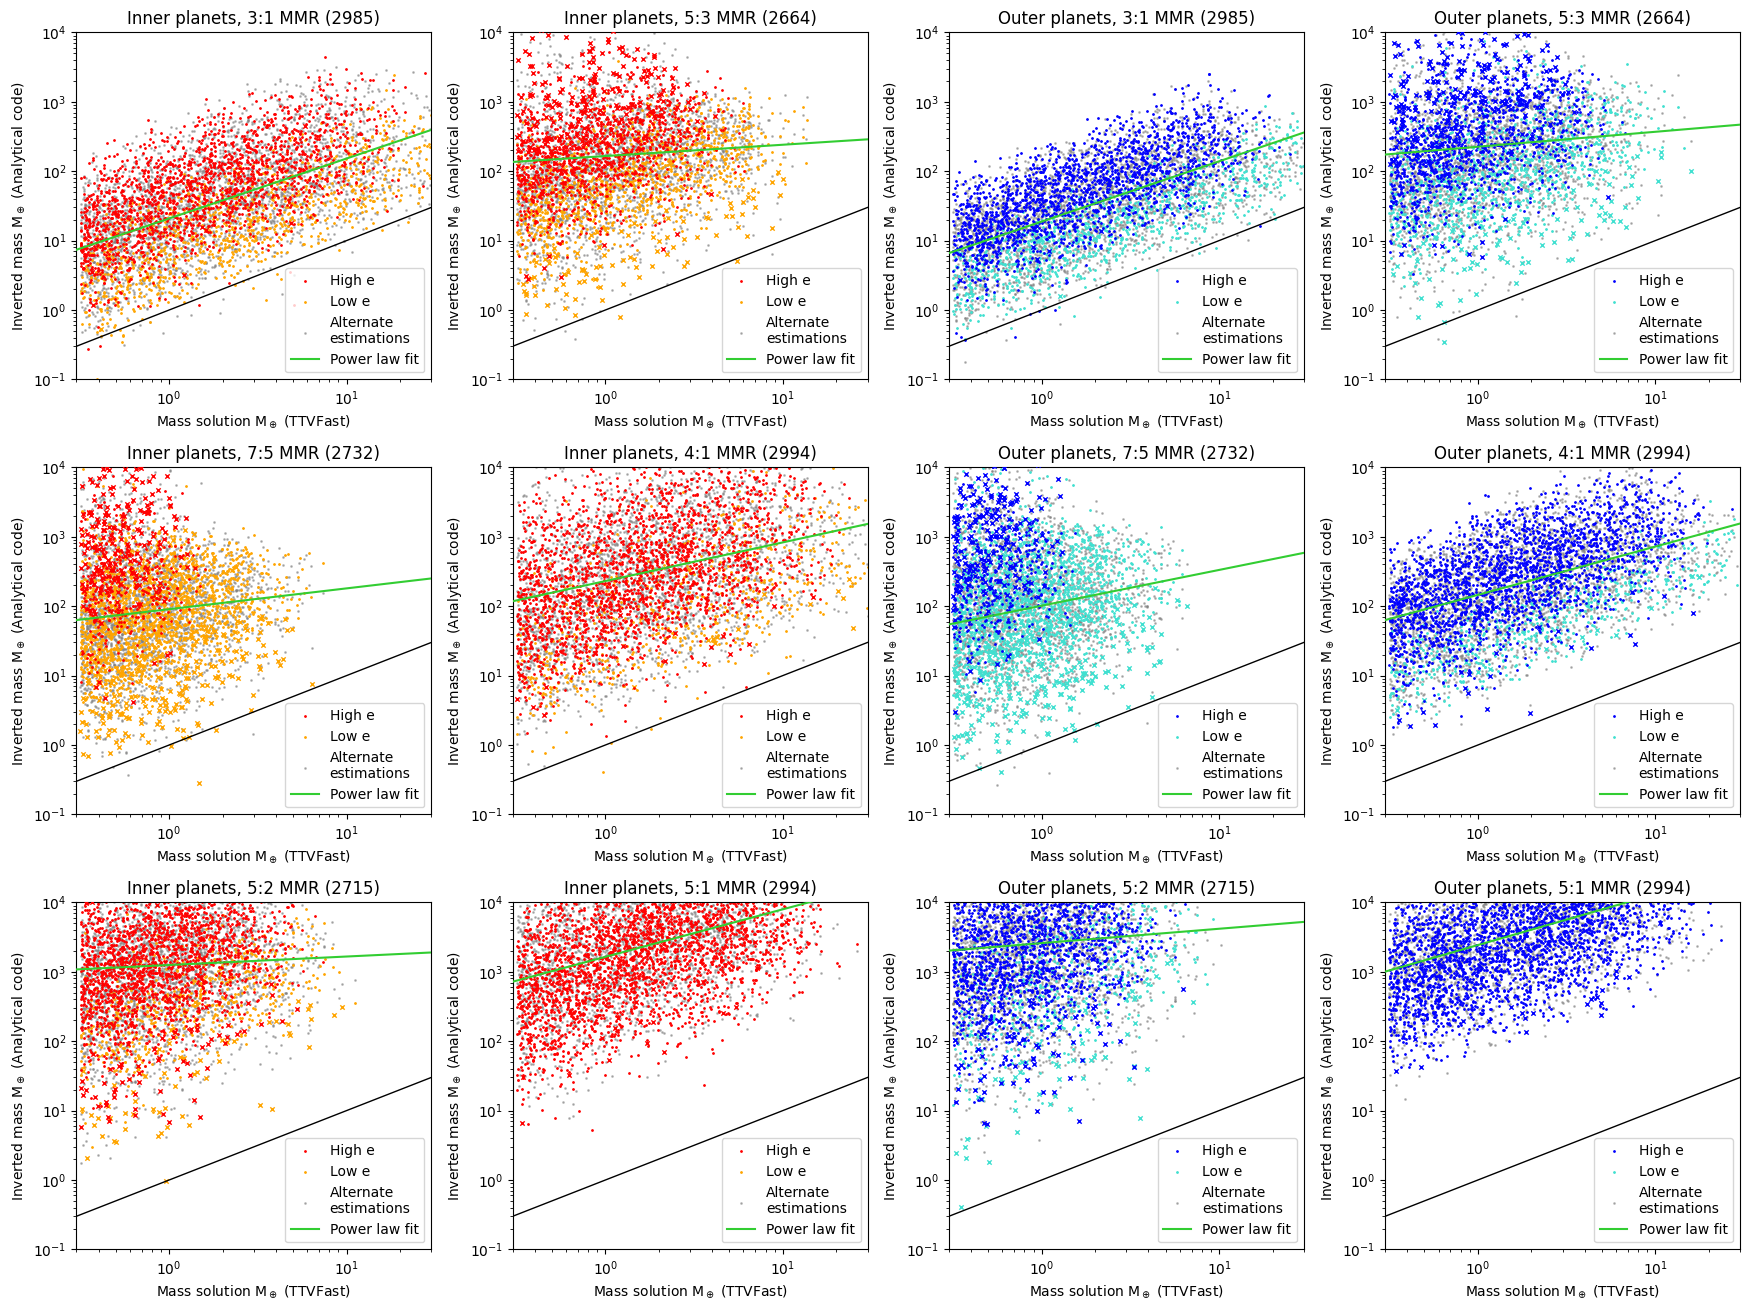

In [29]:
# Divide by regimes
fig, ax = plt.subplots(3, 4, figsize=(16*1.1, 12*1.1))
plotMassWithRegimes(compare_n, xval=(3e-1, 3e+1), yval=(1e-1, 1e+4))
fig.tight_layout()
plt.show()

In [17]:
# Relative bias and average error
err1, err2, med1, med2, gstd1, gstd2 = returnMetrics(compare_n, mask='all')

print(f'Geometric mean error, median error, and geometric STD (Inner): {err1:.3f} dex, {med1:.3f} dex, {gstd1:.3f} dex')
print(f'Geometric mean error, median error, and geometric STD (Outer): {err2:.3f} dex, {med2:.3f} dex, {gstd2:.3f} dex')

Geometric mean error, median error, and geometric STD (Inner): 2.277 dex, 2.238 dex, 0.931 dex
Geometric mean error, median error, and geometric STD (Outer): 2.378 dex, 2.319 dex, 1.002 dex


# Metric compilation

In [18]:
# Metric summarized in dataframe
metricCols = ['regime', 'count', 'GMerr', 'GMerr_n', 'MedErr', 'MedErr_n', 'p16Err', 'p16Err_n', 'p84Err', 'p84Err_n']
metrics = pd.DataFrame(columns=metricCols)
metrics.regime = ['Inner (Overall)', 'Inner (Overall, low e)', 'Inner (Overall, high e)',
                  'Inner (3:1 MMR, low e)', 'Inner (5:3 MMR, low e)', 'Inner (7:5 MMR, low e)',
                  'Inner (4:1 MMR, low e)', 'Inner (5:2 MMR, low e)', 'Inner (5:1 MMR, low e)',
                  'Inner (3:1 MMR, high e)', 'Inner (5:3 MMR, high e)', 'Inner (7:5 MMR, high e)',
                  'Inner (4:1 MMR, high e)', 'Inner (5:2 MMR, high e)', 'Inner (5:1 MMR, high e)',
                  'Outer (Overall)', 'Outer (Overall, low e)', 'Outer (Overall, high e)',
                  'Outer (3:1 MMR, low e)', 'Outer (5:3 MMR, low e)', 'Outer (7:5 MMR, low e)',
                  'Outer (4:1 MMR, low e)', 'Outer (5:2 MMR, low e)', 'Outer (5:1 MMR, low e)',
                  'Outer (3:1 MMR, high e)', 'Outer (5:3 MMR, high e)', 'Outer (7:5 MMR, high e)',
                  'Outer (4:1 MMR, high e)', 'Outer (5:2 MMR, high e)', 'Outer (5:1 MMR, high e)']
metrics.head()

regime count GMerr GMerr_n MedErr MedErr_n p16Err  \
0          Inner (Overall)   NaN   NaN     NaN    NaN      NaN    NaN   
1   Inner (Overall, low e)   NaN   NaN     NaN    NaN      NaN    NaN   
2  Inner (Overall, high e)   NaN   NaN     NaN    NaN      NaN    NaN   
3   Inner (3:1 MMR, low e)   NaN   NaN     NaN    NaN      NaN    NaN   
4   Inner (5:3 MMR, low e)   NaN   NaN     NaN    NaN      NaN    NaN   

  p16Err_n p84Err p84Err_n  
0      NaN    NaN      NaN  
1      NaN    NaN      NaN  
2      NaN    NaN      NaN  
3      NaN    NaN      NaN  
4      NaN    NaN      NaN

In [19]:
# Regime definitions
def mmrmask(mmr): 
    return (compare.mmr == mmr)

# Create values to insert
def createListToInsert(innerOuterStr, m):
    err1, err2, med1, med2, p16_1, p84_1, p16_2, p84_2 = returnMetrics(compare, mask=m, mode='percentile')
    err1n, err2n, med1n, med2n, p16_1n, p84_1n, p16_2n, p84_2n = returnMetrics(compare_n, mask=m, mode='percentile')

    if innerOuterStr == 'Inner':
        metrics = [err1, err1n, med1, med1n, p16_1, p16_1n, p84_1, p84_1n]
    elif innerOuterStr == 'Outer':
        metrics = [err2, err2n, med2, med2n, p16_2, p16_2n, p84_2, p84_2n]

    count = len(compare.m1) if (isinstance(m, str) == True) else len(compare.m1[m])
    return [count, *metrics]

rows = []
mmr_list = ['3:1', '5:3', '7:5', '4:1', '5:2', '5:1']

for ioStr in ['Inner', 'Outer']:
    for regime in ['all', lowe, highe,
                   *[mmrmask(mmr) & lowe for mmr in mmr_list],
                   *[mmrmask(mmr) & highe for mmr in mmr_list]]:
        if (regime == (mmrmask('5:1') & lowe)).all() == True:
            rowi = [0] + [np.nan] * 8
        else:
            rowi = createListToInsert(ioStr, m=regime)
        rows.append(rowi)

# Inserting time
for i, r in enumerate(rows):
    metrics.loc[i, metricCols[1:]] = r

metrics

regime  count     GMerr   GMerr_n    MedErr  MedErr_n  \
0           Inner (Overall)  17084 -0.010021  2.277485 -0.012214  2.237582   
1    Inner (Overall, low e)   5708 -0.001052    1.6696 -0.000867  1.682242   
2   Inner (Overall, high e)  11376 -0.014521  2.582496 -0.020437   2.59302   
3    Inner (3:1 MMR, low e)   1048 -0.005023  0.840901   -0.0033  0.816348   
4    Inner (5:3 MMR, low e)   1241 -0.002397  1.670636 -0.002268  1.696405   
5    Inner (7:5 MMR, low e)   2143 -0.002122  1.898077  0.000559  1.910255   
6    Inner (4:1 MMR, low e)    642  0.014764  1.576681   0.00923  1.490511   
7    Inner (5:2 MMR, low e)    634 -0.004259  2.359221 -0.003465  2.376601   
8    Inner (5:1 MMR, low e)      0       NaN       NaN       NaN       NaN   
9   Inner (3:1 MMR, high e)   1937 -0.017569  1.524326 -0.015472  1.521633   
10  Inner (5:3 MMR, high e)   1423   0.05888  2.401495  0.003064  2.367622   
11  Inner (7:5 MMR, high e)    589   0.14677  2.794844  0.024009  2.739431   
12  Inner (4:1 MMR, high e)   2352 -0.020571   2.35359 -0.023679   2.29797   
13  Inner (5:2 MMR, high e)   2081 -0.027023  3.168456  -0.02702  3.180518   
14  Inner (5:1 MMR, high e)   2994 -0.065722  3.083888 -0.058519  3.095491   
15          Outer (Overall)  17084 -0.015675  2.377804 -0.017894  2.319244   
16   Outer (Overall, low e)   5708 -0.004671  1.763471 -0.002621  1.704307   
17  Outer (Overall, high e)  11376 -0.021196   2.68605 -0.028007  2.674527   
18   Outer (3:1 MMR, low e)   1048 -0.006891  0.810314 -0.010413   0.81671   
19   Outer (5:3 MMR, low e)   1241 -0.005128  1.834418 -0.008505  1.815735   
20   Outer (7:5 MMR, low e)   2143  -0.00198  2.021757   0.00058  2.027919   
21   Outer (4:1 MMR, low e)    642 -0.006453  1.403035 -0.000634  1.402777   
22   Outer (5:2 MMR, low e)    634 -0.007399  2.692111 -0.003211   2.64487   
23   Outer (5:1 MMR, low e)      0       NaN       NaN       NaN       NaN   
24  Outer (3:1 MMR, high e)   1937 -0.021775  1.466864  -0.02255  1.474421   
25  Outer (5:3 MMR, high e)   1423  0.056774  2.565424  0.004158  2.536005   
26  Outer (7:5 MMR, high e)    589  0.144606  2.912444  0.023135  2.864608   
27  Outer (4:1 MMR, high e)   2352 -0.029294  2.214952 -0.030447  2.230581   
28  Outer (5:2 MMR, high e)   2081 -0.029856  3.513133 -0.031087  3.485593   
29  Outer (5:1 MMR, high e)   2994 -0.078114   3.28282 -0.077558  3.283962   

      p16Err  p16Err_n    p84Err  p84Err_n  
0  -0.061221  1.319021  0.029146  3.264652  
1  -0.027561  0.899226  0.025356  2.401615  
2  -0.080015   1.65716  0.034006  3.485295  
3  -0.031599  0.426098  0.022779  1.285976  
4  -0.024967  1.181345   0.02286  2.151346  
5   -0.02502  1.290457  0.019911  2.507902  
6  -0.054909  0.950504  0.100333  2.216749  
7   -0.02682  1.869025  0.019533  2.885658  
8        NaN       NaN       NaN       NaN  
9  -0.048966   1.04294  0.020248  2.031392  
10 -0.036055  1.856199  0.090474  2.911461  
11 -0.032492  2.136087  0.368051  3.502979  
12 -0.060818  1.595428  0.018903  3.106319  
13 -0.058199  2.542772  0.000796  3.797033  
14 -0.229245  2.419161   0.08652  3.736422  
15 -0.062181  1.342421  0.020332  3.425895  
16 -0.030163  0.938066  0.019363  2.581157  
17 -0.084567  1.684669  0.021535   3.66475  
18 -0.032587  0.477918  0.022114  1.140506  
19 -0.030755  1.290284  0.021443  2.384697  
20 -0.026519  1.357131  0.019067  2.700408  
21 -0.034029  1.082936   0.01964    1.7138  
22 -0.028927  2.053042  0.011822  3.395527  
23       NaN       NaN       NaN       NaN  
24 -0.052759  1.078172  0.021784   1.88455  
25 -0.039076  1.966897  0.085008  3.164988  
26 -0.036018  2.188856  0.360502  3.662853  
27 -0.060683  1.731071  0.006742   2.72581  
28 -0.059149  2.729704  -0.00114   4.31679  
29 -0.215704  2.687241  0.049996  3.866979

In [20]:
# Export metrics
metrics.to_csv('deckagol_code_metrics.csv', index=False)

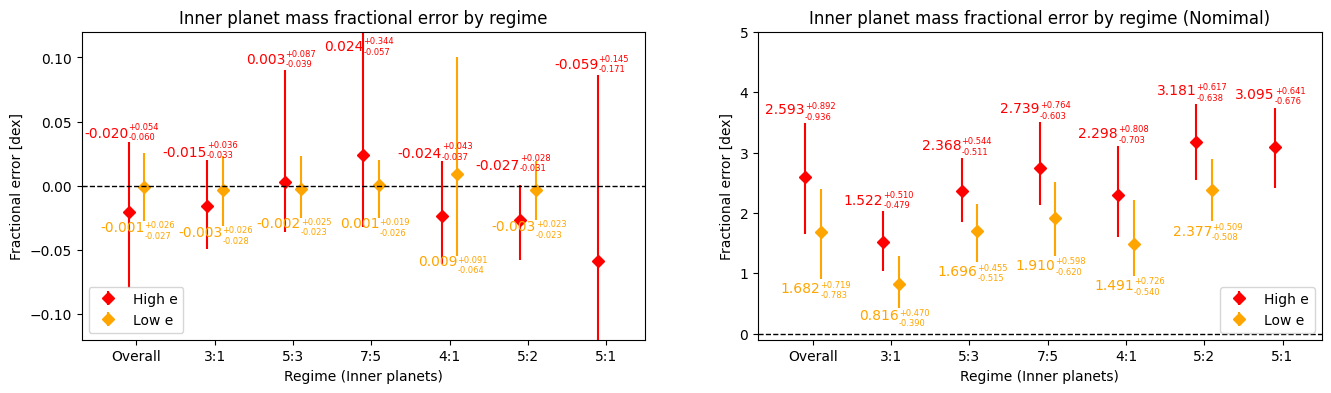

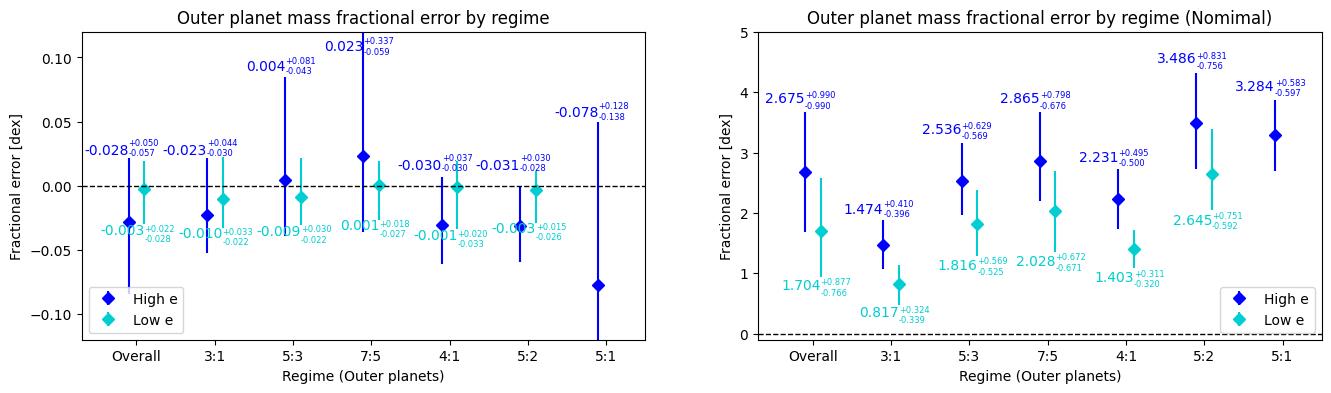

In [30]:
# Plot visualization
inner = metrics[0:15]; outer = metrics[15:30]

def metricPlots(df, innerOuterStr):
    regimenames = ['Overall', *mmr_list]
    ethres = 0.01
    highe = (compare.e1 > ethres) & (compare.e2 > ethres); lowe = ~highe
    
    colnames = ['Regime', 'Count', 'Geometric Mean Error [dex]', 'Geometric Mean Error (Nominal) [dex]',
                'Median Error [dex]', 'Median Error (Nominal) [dex]',
                'Error at 16th Percentile [dex]', 'Error at 16th Percentile (Nominal) [dex]',
                'Error at 84th Percentile [dex]', 'Error at 84th Percentile (Nominal) [dex]']

    # Define dfs of lowe and highe
    df_lowe = df.iloc[[1,3,4,5,6,7,8]]
    df_highe = df.iloc[[2,9,10,11,12,13,14]]

    # Extract errorbars
    def get_yerr(df_):
        yerr_lower = df_.MedErr - df_.p16Err
        yerr_upper = df_.p84Err - df_.MedErr
        yerr = [yerr_lower, yerr_upper]
        
        yerrn_lower = df_.MedErr_n - df_.p16Err_n
        yerrn_upper = df_.p84Err_n - df_.MedErr_n
        yerrn = [yerrn_lower, yerrn_upper]

        return yerr, yerrn
    
    yerr_lowe, yerrn_lowe = get_yerr(df_lowe)
    yerr_highe, yerrn_highe = get_yerr(df_highe)

    # Text color customization
    if innerOuterStr == "Inner":
        color_highe = 'red'; color_lowe = 'orange'
    elif innerOuterStr == "Outer":
        color_highe = 'blue'; color_lowe = 'darkturquoise'

    # Shift scatterplot to the left and right
    shift = 0.1
    x = np.arange(len(regimenames))
    xpos_highe = x - shift
    xpos_lowe = x + shift

    # Plot the graph
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    ax[0].errorbar(x=xpos_highe, y=df_highe.MedErr, yerr=yerr_highe,
                   fmt='D', linestyle='none', color=color_highe, zorder=1, label='High e')
    ax[0].errorbar(x=xpos_lowe, y=df_lowe.MedErr, yerr=yerr_lowe,
                   fmt='D', linestyle='none', color=color_lowe, zorder=0, label='Low e')
    ax[0].set_title(f'{innerOuterStr} planet mass fractional error by regime')
    ax[0].set_ylim(-0.12, 0.12)
    ax[0].legend(loc='lower left')
    
    ax[1].errorbar(x=xpos_highe, y=df_highe.MedErr_n, yerr=yerrn_highe,
                   fmt='D', linestyle='none', color=color_highe, zorder=1, label='High e')
    ax[1].errorbar(x=xpos_lowe, y=df_lowe.MedErr_n, yerr=yerrn_lowe,
                   fmt='D', linestyle='none', color=color_lowe, zorder=0, label='Low e')
    ax[1].set_title(f'{innerOuterStr} planet mass fractional error by regime (Nomimal)')
    ax[1].set_ylim(-0.1, 5.0)
    ax[1].legend(loc='lower right')

    for i in range(7): # Text
        text_x_high, text_x_low = xpos_highe[i], xpos_lowe[i]
        s1 = 10
        s2 = 6

        def showText(df_, color, xpos):      
            upper = df_['p84Err'].iloc[i] - df_['MedErr'].iloc[i]
            lower = df_['MedErr'].iloc[i] - df_['p16Err'].iloc[i]
            # Limit text
            if color == color_highe:
                ypos = np.nan_to_num(np.clip(df_['p84Err'].iloc[i], 0.01, 0.1), nan=np.nan)
                scale1, scale2 = 1.03, 1.01
                va = 'bottom'
            elif color == color_lowe:
                ypos = min(df_['p16Err'].iloc[i], -0.02)
                scale1, scale2 = 0.97, 0.99
                va = 'top'
            
            # Put text in
            if not np.isnan(ypos):
                ax[0].text(  # Median report
                    xpos,
                    ypos * scale1,
                    f'{df_.MedErr.iloc[i]:.3f}',
                    fontsize=s1, color=color,
                    ha='right', va=va
                )
                ax[0].text(  # Errorbar report
                    xpos,
                    ypos * scale2,
                    f'+{upper:.3f}\n-{lower:.3f}',
                    fontsize=s2, color=color,
                    ha='left', va=va
                )
        
                upper_n = df_['p84Err_n'].iloc[i] - df_['MedErr_n'].iloc[i]
                lower_n = df_['MedErr_n'].iloc[i] - df_['p16Err_n'].iloc[i]
                # Again for nominal part of plot
                if color == color_highe:
                    ypos = df_['p84Err_n'].iloc[i]
                elif color == color_lowe:
                    ypos = df_['p16Err_n'].iloc[i]
                
                ax[1].text( # Right plot median + errorbar
                    xpos,
                    ypos * scale1,
                    f'{df_.MedErr_n.iloc[i]:.3f}',
                    fontsize=s1, color=color,
                    ha='right', va=va
                )
                ax[1].text(
                    xpos,
                    ypos * scale2,
                    f'+{upper_n:.3f}\n-{lower_n:.3f}',
                    fontsize=s2, color=color,
                    ha='left', va=va
                )

        showText(df_highe, color_highe, text_x_high)
        showText(df_lowe, color_lowe, text_x_low)

    # Rest of the common plot elements
    for a in ax:
        a.axhline(0, color='black', linestyle='--', linewidth=1)
        a.set_ylabel(f'Fractional error [dex]')
        a.set_xlabel(f'Regime ({innerOuterStr} planets)')
        a.set_xticks(x)
        a.set_xticklabels(regimenames)
        a.margins(x=0.1)

    plt.show()

metricPlots(inner, 'Inner')
metricPlots(outer, 'Outer')